In [1]:
# Imports
# !pip install torchinfo
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time
import TrainingPresets as TP

In [19]:
import model_v01b3 as mymodel

In [3]:
torch.cuda.get_device_name(0)
m1 = mymodel.MyModel().to(torch.device("cuda:1"))
summary(m1, input_size=(2, 90, 100))

Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1, 3]                    --
├─MyEncoder: 1-1                         [1, 128]                  --
│    └─MyEncodeCNN: 2-1                  --                        2,626,048
│    │    └─Sequential: 3-1              [1, 16, 30, 98]           160
│    │    └─Sequential: 3-2              [1, 32, 26, 94]           12,832
│    │    └─Sequential: 3-3              [1, 64, 22, 90]           51,264
│    │    └─Sequential: 3-4              [1, 128, 18, 86]          204,928
│    │    └─Sequential: 3-5              [1, 256, 14, 82]          819,456
│    │    └─Sequential: 3-6              [1, 256, 1, 1]            --
│    └─MyEncodeCNN: 2-2                  --                        2,626,048
│    │    └─Sequential: 3-7              [1, 16, 30, 98]           160
│    │    └─Sequential: 3-8              [1, 32, 26, 94]           12,832
│    │    └─Sequential: 3-9              [1, 64

In [4]:
datadir = '../Dataset/0302make00/'
print(os.listdir(datadir))

['sid.npy', 'csi.npy']


In [5]:
mydata = TP.MyDataset(datadir + 'csi.npy', datadir + 'sid.npy')
print(mydata.data['x'].shape, mydata.data['y'].shape)

train_size = int(len(mydata) * 0.7)
valid_size = int(len(mydata) * 0.2)
test_size = int(len(mydata)) - train_size - valid_size
print(train_size, valid_size, test_size)

train_loader, valid_loader, test_loader = TP.split_loader(mydata, train_size, valid_size, test_size, 8)

loaded
(3000, 2, 100, 90) (3000,)
2100 600 300
2100 600 300


In [6]:
# Hyperparameters
args = TP.MyArgs(cuda=1, epochs=100, learning_rate=0.001, criterion=nn.CrossEntropyLoss())

In [24]:
# Model and Loss

model = mymodel.MyModel().to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

train_loss = []
valid_loss = []
train_epochs_loss = []
valid_epochs_loss = []

# early_stopping = EarlyStopping(patience=args.patience,verbose=True)

In [25]:
# Training and Saving
start = time.time()

for epoch in range(args.epochs):
    model.train()
    train_epoch_loss = []
    for idx,(data_x,data_y) in enumerate(train_loader,0):
        data_x = data_x.to(torch.float32).to(args.device)
        data_y = data_y.to(torch.long).to(args.device)
        optimizer.zero_grad()
        outputs = model(data_x)
        loss = args.criterion(outputs, data_y)
        loss.backward()
        optimizer.step()
        train_epoch_loss.append(loss.item())
        train_loss.append(loss.item())
        if idx%(len(train_loader)//2)==0:
            print("\repoch={}/{},{}/{}of train, loss={}".format(
            epoch, args.epochs, idx, len(train_loader),loss.item()), end='')
    train_epochs_loss.append(np.average(train_epoch_loss))

end = time.time()
print("\nTotal training time:", end-start, "sec")

epoch=1/100,0/262of train, loss=0.0.02171716690063

KeyboardInterrupt: 

In [10]:
  #=====================valid============================
model.eval()
valid_epoch_loss = []
for idx,(data_x,data_y) in enumerate(valid_loader,0):
    data_x = data_x.to(torch.float32).to(args.device)
    data_y = data_y.to(torch.long).to(args.device)
    outputs = model(data_x)
    loss = args.criterion(outputs,data_y)
    valid_epoch_loss.append(loss.item())
    valid_loss.append(loss.item())
valid_epochs_loss.append(np.average(valid_epoch_loss))

  #==================early stopping======================
  # early_stopping(valid_epochs_loss[-1],model=MyModel,path=r'')
  # if early_stopping.early_stop:
  #    print("Early stopping")
  #    break
  #====================adjust lr========================
lr_adjust = {
    2: 5e-5, 4: 1e-5, 6: 5e-6, 8: 1e-6,
    10: 5e-7, 15: 1e-7, 20: 5e-8
}
  #if epoch in lr_adjust.keys():
  #    lr = lr_adjust[epoch]
  #    for param_group in optimizer.param_groups:
  #        param_group['lr'] = lr
  #    print('Updating learning rate to {}'.format(lr))

#torch.save(model.state_dict(), '../Models/v01b2_ep300.pth')


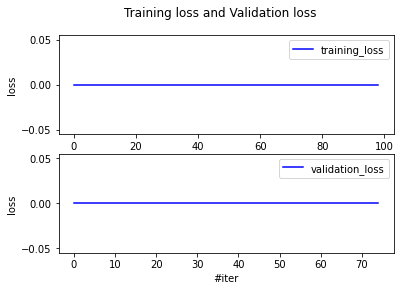

In [11]:
# Plot loss curves

%matplotlib inline
plt.figure()
plt.clf()
plt.suptitle("Training loss and Validation loss")
plt.subplot(2, 1, 1)
plt.plot(train_epochs_loss[1:], 'b', label = 'training_loss')
plt.ylabel('loss')
plt.xlabel('#epoch')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(valid_loss, 'b', label = 'validation_loss')
plt.ylabel('loss')
plt.xlabel('#iter')
plt.legend()
#plt.savefig("loss_900epoch_down.jpg")

In [22]:
  #=====================test============================
estimate = []
test_loss = []
ground_truth = []
model.eval()
for idx,(data_x,data_y) in enumerate(test_loader,0):
    data_x = data_x.to(torch.float32).to(args.device)
    data_y = data_y.to(torch.long).to(args.device)
    outputs = model(data_x)
    loss = args.criterion(outputs,data_y)
    estimate.append(outputs.cpu().detach().numpy().squeeze().tolist())
    ground_truth.append(data_y.cpu().detach().numpy().squeeze().tolist())
    test_loss.append(loss.item())
    if idx%(len(test_loader)//5)==0:
        print("\r{}/{}of test, loss={}".format(
        idx, len(test_loader),loss.item()), end='')

240/300of test, loss=0.0

Text(30.5, 0.5, 'true')

<Figure size 432x288 with 0 Axes>

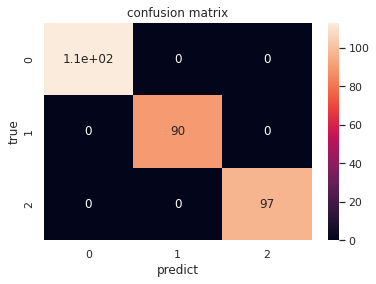

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
%matplotlib inline

def fromonehot(inlist):
    out = []
    for item in inlist:
        if np.argmax(item) == 0:
            out.append(0)
        elif np.argmax(item) == 1:
            out.append(1)
        elif np.argmax(item) == 2:
            out.append(2)
    return out

predicted = [np.argmax(row) for row in estimate]

plt.figure()
sns.set()
f,ax=plt.subplots()
cf = confusion_matrix(ground_truth, predicted)

sns.heatmap(cf,annot=True,ax=ax) 

ax.set_title('confusion matrix') 
ax.set_xlabel('predict') 
ax.set_ylabel('true')